# Notebook Narritive
Problem: Imagine someone sitting in front on their computer... combing through pages and pages of recipes... trying to find out what to eat for supper. 
Well, look no more! If you have strong opinions about food this app is here to help. 
Enter a set of ingredients that you like, those you don’t,  and it will recommend a good recipe for you. 


Solution: Create 'Picked For Me', a content-based recommendation system for recipes based on ‘similar’ ingredients.


Goals of this notebook:
1.   EDA (continued)
2.   Impliment word2vec
3.   Impliment TF-IDF methods
4.   Combine methods and add user interaction





## Preliminary Work
Import dependencies for this notebook.

In [0]:
import pandas as pd
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
#import nltk
#from nltk.corpus import stopwords
#from nltk import SnowballStemmer as snow
import sklearn
import sklearn.metrics

Load recipe file (saved as a pickle) as a DataFrame.

In [0]:
file = '/content/recipe_data_220k.pkl'
df = pd.read_pickle(file)

Only use a subset of the data, for computational restrictions.

In [0]:
df = df.iloc[:10000]

# EDA
View the headers and the first few rows of the DataFrame.

In [362]:
print(df.shape)
df.head()

(10000, 2)


,name,ingredients
id,,
137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ..."
31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg..."
112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato..."
59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n..."
44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar..."


What is the data type of the ingredients?


In [7]:
type(df.ingredients.iloc[0])

str

Hm.... a string. Note: will need to preprocess the ingredients and turn the string into a list.


# word2vec Work
Goal: use word2vec to compare ingredients.
First, preprocess the data into a list.


In [0]:
# Preprocessing the ingredients strings into a list format that word2vec will use
documents = df.ingredients.str.replace('[', '').str.replace(']', '').str.split(', ').tolist()     

Create a model using the gensim library.

In [174]:
# --size=N: dimensions of N-D space Word2Vec maps the words onto (bigger can lead to more accurate models)
# --workers: =1 for 1 core (install Cython to increase number and decrease speed time)
# --min_count: is for pruning the internal dictionary, want 0 since we want the initial ingred. set from
#   the recipies to be the same set when we search for recipies from the tf-idf vectorizer 
model = gensim.models.Word2Vec(documents, size=200, min_count=0, workers=1)

2020-01-30 21:30:47,588 : INFO : collecting all words and their counts
2020-01-30 21:30:47,593 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-30 21:30:47,624 : INFO : collected 5336 word types from a corpus of 84002 raw words and 10000 sentences
2020-01-30 21:30:47,625 : INFO : Loading a fresh vocabulary
2020-01-30 21:30:47,638 : INFO : effective_min_count=0 retains 5336 unique words (100% of original 5336, drops 0)
2020-01-30 21:30:47,639 : INFO : effective_min_count=0 leaves 84002 word corpus (100% of original 84002, drops 0)
2020-01-30 21:30:47,658 : INFO : deleting the raw counts dictionary of 5336 items
2020-01-30 21:30:47,659 : INFO : sample=0.001 downsamples 64 most-common words
2020-01-30 21:30:47,660 : INFO : downsampling leaves estimated 67684 word corpus (80.6% of prior 84002)
2020-01-30 21:30:47,674 : INFO : estimated required memory for 5336 words and 200 dimensions: 11205600 bytes
2020-01-30 21:30:47,675 : INFO : resetting layer weights

Train the model on the corpus.

In [175]:
# --total_examples: # of 'sentences' (== recipes)
# --epochs: number of iterations over the corpus (more epochs can improve results)
model.train(documents, total_examples=len(documents), epochs=10)

2020-01-30 21:30:57,708 : WARNING : Effective 'alpha' higher than previous training cycles
2020-01-30 21:30:57,710 : INFO : training model with 1 workers on 5336 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2020-01-30 21:30:57,902 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-30 21:30:57,903 : INFO : EPOCH - 1 : training on 84002 raw words (67699 effective words) took 0.2s, 374767 effective words/s
2020-01-30 21:30:58,088 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-30 21:30:58,089 : INFO : EPOCH - 2 : training on 84002 raw words (67723 effective words) took 0.2s, 386614 effective words/s
2020-01-30 21:30:58,272 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-30 21:30:58,273 : INFO : EPOCH - 3 : training on 84002 raw words (67763 effective words) took 0.2s, 392077 effective words/s
2020-01-30 21:30:58,458 : INFO : worker thread finished; awaiting finish of 0 more threa

(677135, 840020)

Explore the model.

In [105]:
#look at the similarity score of words
model.wv.similarity("'cod'", "'kale'")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.98222053

In [106]:
#look for similar words
model.wv.most_similar ("'kale'")

2020-01-30 19:43:44,848 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[("'cilantro leaves'", 0.9934511184692383),
 ("'thai fish sauce'", 0.9933560490608215),
 ("'spring onions'", 0.993165135383606),
 ("'spaghettini'", 0.9921862483024597),
 ("'skewer'", 0.9911653995513916),
 ("'dried cranberry beans'", 0.9908280372619629),
 ("'raw cashews'", 0.9908053278923035),
 ("'russet potato'", 0.990509569644928),
 ("'oyster mushrooms'", 0.9903908967971802),
 ("'dried chilies'", 0.9898481369018555)]

Plotting the clusters of ingredients; code adapted from [this](https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d) blog post.

In [0]:
keys = ["'squash'", "'cod'", "'kale'", "'beef'"]

In [52]:
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [0]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


2020-01-30 18:36:27,226 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-01-30 18:36:27,235 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-01-30 18:36:27,246 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2020-01-30 18:36:27,255 : WARNING : 'c' arg

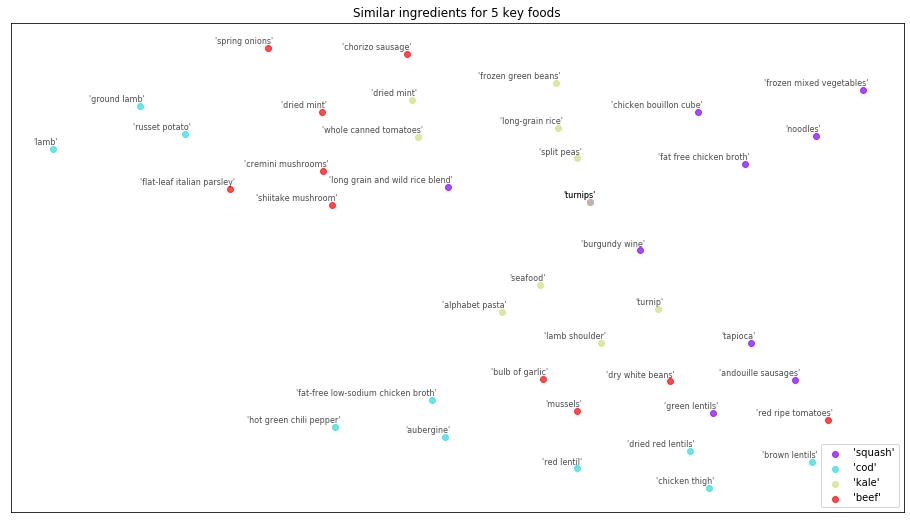

In [61]:
tsne_plot_similar_words('Similar ingredients for 5 key foods', keys, embeddings_en_2d, word_clusters, 0.7)

## TF-IDF Work
Prework

Create a function that tokenizes the recipe text in the tf-idf process that matches the word2vec tokenization.

In [0]:
def tokens_test(x):
  """ This function takes a string input and only splits on the comma between ingredients."""
  return x.split(', ')

Do some preprocessing of the ingredient strings: delete the brackets.

In [177]:
df.ingredients = df.ingredients.str.replace('[', '')
df.ingredients = df.ingredients.str.replace(']', '')
df.ingredients

id
137739    'winter squash', 'mexican seasoning', 'mixed s...
31490     'prepared pizza crust', 'sausage patty', 'eggs...
112140    'ground beef', 'yellow onions', 'diced tomatoe...
59389     'spreadable cheese with garlic and herbs', 'ne...
44061     'tomato juice', 'apple cider vinegar', 'sugar'...
                                ...                        
450592    'large shrimp', 'sweetened coconut', 'panko br...
260940    'olive oil', 'onion', 'garlic', 'chopped tomat...
332128    'cod fish fillets', 'butter', 'tomatoes', 'gre...
383814    'extra virgin olive oil', 'onions', 'button mu...
347236    'anise', 'onion', 'lemon', 'salt and pepper', ...
Name: ingredients, Length: 10000, dtype: object

In [0]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=tokens_test)

In [0]:
response = tfidf.fit_transform(df.ingredients)

In [180]:
df_tfidf = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names(), index=df.index)
df_tfidf

,"""baker's semi-sweet baking chocolate""","""campbell's cream of chicken soup""","""campbell's cream of mushroom soup""","""campbell's golden mushroom soup""","""campbell's healthy request cream of broccoli soup""","""campbell's tomato soup""","""coleman's dry mustard""","""confectioners' sugar""","""devil's food cake mix""","""eggland's best large egg""","""frank's red hot sauce""","""french's cheddar french fried onions""","""french's french fried onions""","""french's mustard""","""hellmann's mayonnaise""","""i can't believe it's not butter spread""","""i can't believe it's not butter! spray""","""instant devil's food pudding""","""lawry's seasoned pepper""","""lawry's seasoned salt""","""libby's canned pumpkin""","""m&m's plain chocolate candy""","""mac n' cheese deluxe""","""mccormick's montreal brand steak seasoning""","""meyer's dark rum""","""mrs richardson's caramel topping""","""o'brien frozen potatoes""","""o'brien potatoes""","""red bird's eye chili""","""reese's peanut butter cups""","""sweet 'n low""","""tony chachere's seasoning""","""uncle ben's converted brand rice""","""za'atar spice mix""",'1% fat buttermilk','1% low-fat milk','10 bean soup mix','10-inch deep dish pie crust','12-inch pizza crust','15 bean mix',...,'yellow cornmeal','yellow food coloring','yellow hominy','yellow lentils','yellow mustard seeds','yellow mustard','yellow onion','yellow onions','yellow pepper','yellow peppers','yellow potatoes','yellow rice','yellow snapper fillets','yellow split peas','yellow squash','yellow sweet onion','yellow sweet pepper','yellow taro root','yellow wax bean','yellow wax beans','yellow zucchini','yoghurt','yogurt cheese','yogurt','young ginger root','your favorite liqueur','yucca root','yukon gold potato','yukon gold potatoes','zatarians gumbo base mix','ziploc bag','ziploc bags','ziti pasta','zucchini with italian-style tomato sauce','zucchini',juice and rind of',juice and zest of',juice of',rind of',zest of'
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [181]:
cosine_similarity_array = sklearn.metrics.pairwise.cosine_similarity(df_tfidf)
df_similarity = pd.DataFrame(cosine_similarity_array, columns=df_tfidf.index).set_index(df_tfidf.index)
df_similarity.head()

id,137739,31490,112140,59389,44061,5289,25274,67888,70971,109439,42198,67547,107517,39959,43026,23933,8559,23850,76808,49262,48156,54272,47366,37073,44123,59952,93249,54100,67664,87098,25775,33165,38798,22123,90921,58224,33606,94710,35173,52804,...,212616,438693,425245,90986,114926,146017,11135,226841,449868,509019,297771,195518,446975,326385,253442,191765,80644,155956,102048,372540,18398,486001,355510,196239,382940,145284,354219,49923,97985,44526,30436,165084,154307,502862,143530,450592,260940,332128,383814,347236
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137739,1.000000,0.0,0.017045,0.046421,0.018572,0.000000,0.0,0.050518,0.0,0.0,0.034746,0.017594,0.019176,0.0,0.000000,0.0,0.0,0.000000,0.020707,0.073611,0.000000,0.017996,0.015093,0.0,0.0,0.016282,0.047933,0.017814,0.000000,0.000000,0.021253,0.015518,0.000000,0.000000,0.06717,0.000000,0.023190,0.0,0.025644,0.000000,...,0.030703,0.055976,0.015321,0.000000,0.015155,0.036293,0.011980,0.000000,0.045800,0.000000,0.0,0.0,0.032421,0.055049,0.034576,0.036633,0.000000,0.032694,0.049586,0.043511,0.042906,0.031616,0.0,0.0,0.066404,0.050931,0.0,0.029479,0.030828,0.027332,0.000000,0.024395,0.000000,0.024847,0.020202,0.015075,0.048504,0.028642,0.0,0.064591
31490,0.000000,1.0,0.000000,0.000000,0.000000,0.076615,0.0,0.000000,0.0,0.0,0.055674,0.000000,0.000000,0.0,0.125485,0.0,0.0,0.035903,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.077044,0.000000,0.000000,0.000000,0.052968,0.000000,0.00000,0.000000,0.117061,0.0,0.000000,0.047293,...,0.000000,0.000000,0.000000,0.042401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.124834,0.112691,0.111411,0.168972,0.000000,0.000000,0.050660,0.0,0.0,0.000000,0.000000,0.0,0.111274,0.000000,0.000000,0.000000,0.000000,0.000000,0.044858,0.000000,0.000000,0.000000,0.053798,0.0,0.057230
112140,0.017045,0.0,1.000000,0.014352,0.015590,0.000000,0.0,0.067511,0.0,0.0,0.000000,0.098884,0.016097,0.0,0.000000,0.0,0.0,0.017898,0.047080,0.024408,0.077241,0.268379,0.034316,0.0,0.0,0.111731,0.000000,0.040503,0.000000,0.082936,0.017841,0.013026,0.000000,0.056146,0.00000,0.068282,0.000000,0.0,0.046500,0.027637,...,0.000000,0.017306,0.012861,0.167991,0.222420,0.075126,0.069333,0.000000,0.000000,0.052105,0.0,0.0,0.027216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.022019,0.016888,0.0,0.000000,0.000000,0.000000,0.059354,0.020478,0.000000,0.000000,0.016959,0.012655,0.088471,0.000000,0.0,0.028530
59389,0.046421,0.0,0.014352,1.000000,0.048401,0.000000,0.0,0.010114,0.0,0.0,0.000000,0.014813,0.016146,0.0,0.000000,0.0,0.0,0.045054,0.017435,0.024482,0.000000,0.015153,0.012708,0.0,0.0,0.042433,0.000000,0.014999,0.000000,0.000000,0.017895,0.040440,0.000000,0.000000,0.00000,0.000000,0.019526,0.0,0.000000,0.000000,...,0.025851,0.114237,0.012900,0.000000,0.012761,0.030558,0.010087,0.000000,0.038562,0.000000,0.0,0.0,0.027298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.068358,0.052429,0.0,0.000000,0.065518,0.000000,0.000000,0.063576,0.000000,0.000000,0.017010,0.012693,0.072353,0.000000,0.0,0.028730
44061,0.018572,0.0,0.015590,0.048401,1.000000,0.000000,0.0,0.068301,0.0,0.0,0.000000,0.016092,0.017539,0.0,0.000000,0.0,0.0,0.000000,0.018940,0.026595,0.000000,0.016461,0.013805,0.0,0.0,0.046096,0.000000,0.101297,0.000000,0.000000,0.019440,0.068108,0.000000,0.000000,0.00000,0.032781,0.000000,0.0,0.000000,0.000000,...,0.000000,0.018856,0.014013,0.000000,0.013862,0.012226,0.010957,0.032719,0.000000,0.000000,0.0,0.0,0.029654,0.000000,0.000000,0.000000,0.033640,0.000000,0.050441,0.044262,0.000000,0.000000,0.0,0.0,0.074259,0.056955,0.0,0.000000,0.000000,0.000000,0.000000,0.069064,0.021259,0.000000,0.049954,0.013788,0.050573,0.000000,0.0,0.000000


## Combining the results

In [0]:
# look for ingredients that are similar to cod and different from beef and kale
# test for not a valid ingred. set:
#  w1 = ["'cod'", "'squash'", "'rainier cherries'"]
# w1 = ["'cod fillet'", "'squash'"]

w1 = ["'cod'", "'squash'"]
w2 = ["'beef'", "'kale'"]

In [0]:
def length_recipe_list(my_recipe_list):
  """This is a function that limits the length of the returned recipe list"""
  if len(my_recipe_list) <= 5:
    my_range_value = len(my_recipe_list)
    return my_range_value
  else:
    my_range_value = 5
    return my_range_value

In [357]:
try:
  result = model.wv.most_similar(positive=w1, negative=w2)

  my_food_0 = result[0][0]
  my_food_1 = result[1][0]

  choice = 2

  if choice == 1:    
    ##### DONE #####
    # USER -- Choose 1 result
    my_recipe_list = df_tfidf[(df_tfidf[my_food_0] > 0)].index.tolist()  
    if len(my_recipe_list) > 0:
      print(f'Here are some recipes with {my_food_0}:')
      for item in my_recipe_list:
        my_range_value = length_recipe_list(my_recipe_list)
        for i in range(my_range_value):
          print(f'https://www.food.com/recipe/{my_recipe_list[i]}')
    ##### DONE #####

  else:
    ##### DONE: USER -- Choose 2 results
    # This set of 2 ingred tests this path
    # my_food_0 = "'chocolate'"
    # my_food_1 = "'milk'"
    my_food_list = [my_food_0, my_food_1]    

    my_recipe_list = df_tfidf[(df_tfidf[my_food_list[0]] > 0) & 
                                (df_tfidf[my_food_list[1]] > 0)].index.tolist()  
    if len(my_recipe_list) > 0:
      print(f'Here are some recipes with {my_food_list}:')
      for item in my_recipe_list:
        my_range_value = length_recipe_list(my_recipe_list)
        for i in range(my_range_value):
          print(f'https://www.food.com/recipe/{my_recipe_list[i]}')
    ##### DONE ######

except KeyError:
    # Case: the user entered an ingredient that is not in the BOW from corpus
    print(f'There are no recipes with this ingredient set.')
    
    # #try tokenizing the ingredient
    # not_in_recipies = "cherries"
    # my_food_list = not_in_recipies.split(' ')
    
    # for ingredient in my_food_list:
      

    #   # with the split ingred string, try finding individual ingredients
    #   if ingredient in df_tfidf.columns:
    #     print('yes')
    #     my_recipe_list = df_tfidf[df_tfidf[ingredient] > 0].index.tolist()
    #     my_range_value = length_recipe_list(my_recipe_list)
    #     for i in range(my_range_value):
    #       print(f'https://www.food.com/recipe/{my_recipe_list[i]}')

else:
  ##### DONE #####
  # Case: there are no recipes with the 2 chosen ingredients, so find something similar
  print(f'There are no recipes with this ingredient set. Here are some suggestions:')
  my_food_2 = result[2][0]
  my_recipe_list = df_tfidf[df_tfidf[my_food_2] > 0].index.tolist()
  list_secondary = []
  for id_ in my_recipe_list:
    # use the tf-idf cosine similarity to find something similar
    for column_id in df_similarity.columns:     
        # check if the similarity is between values   
          if df_similarity.loc[id_,  column_id] > .01:
            value = df_similarity.loc[id_,  column_id]
            list_secondary.append([column_id, value])
          
    pri_sec_values_df = pd.DataFrame(list_secondary, columns=['secondary', 'cs_value'])
    # sort by cosine similarity value 
    pri_sec_values_df = pri_sec_values_df.sort_values('cs_value')
    if len(pri_sec_values_df) > 4:
      pri_sec_values_df = pri_sec_values_df.tail(5)
    for i in range(5):
       sec_id = int(pri_sec_values_df.iloc[i]['secondary'])
       print(f'https://www.food.com/recipe/{sec_id}')
  ##### DONE #####

  






There are no recipes with this ingredient set. Here are some suggestions:
https://www.food.com/recipe/192298
https://www.food.com/recipe/461488
https://www.food.com/recipe/337893
https://www.food.com/recipe/330512
https://www.food.com/recipe/288322


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
